In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.estela import Predictor
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, TWL, AnnualMaxima, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.climate_emulator import Plot_Simulation
from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])



## Climate Emulator - Fitting

In [4]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Waves and KMA bmus data share time dimension
WVS_fit = WVS.sel(time = DWTs_fit.time)

# Fit extremes model
config = {
    'name_fams':       ['sea', 'swell_1', 'swell_2'],
    'force_empirical': ['sea_Tp'],
}

#CE.FitExtremes(DWTs_fit, WVS_fit, config)


# Load Climate Emulator
CE.Load()

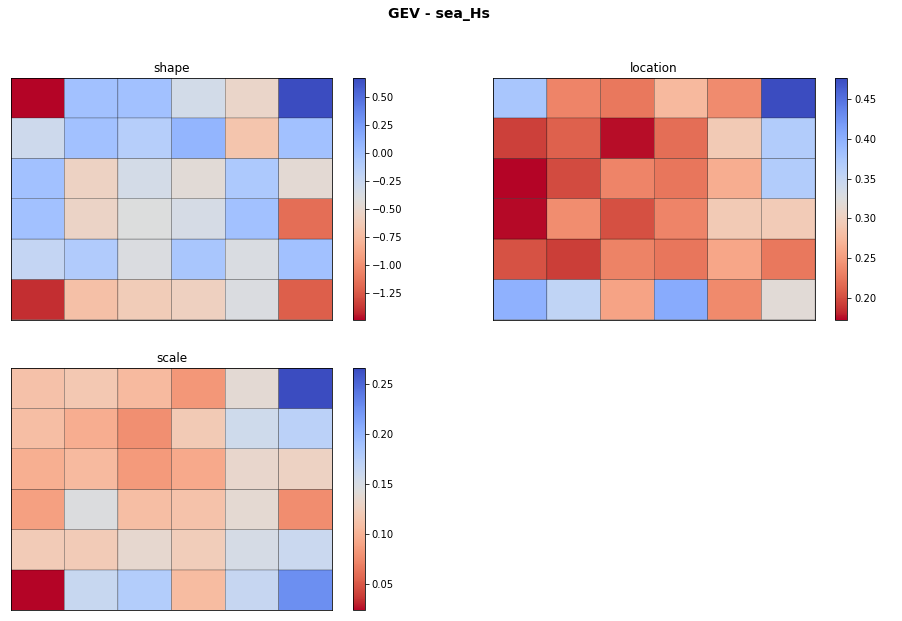

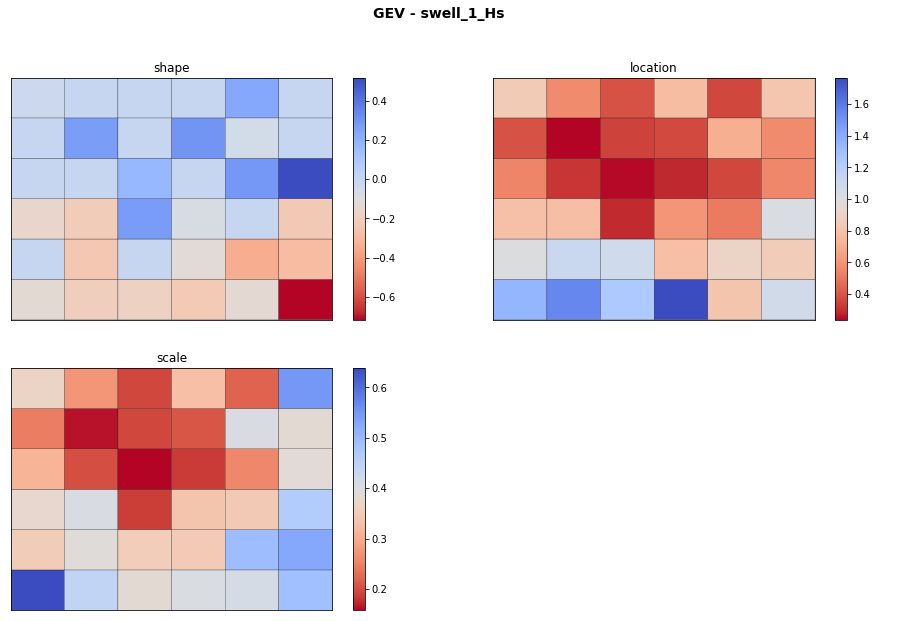

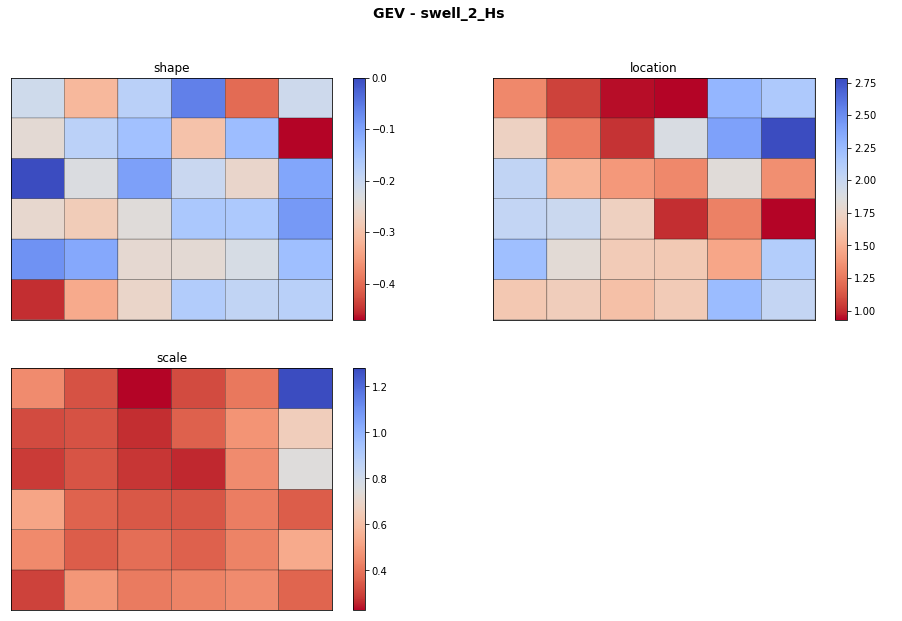

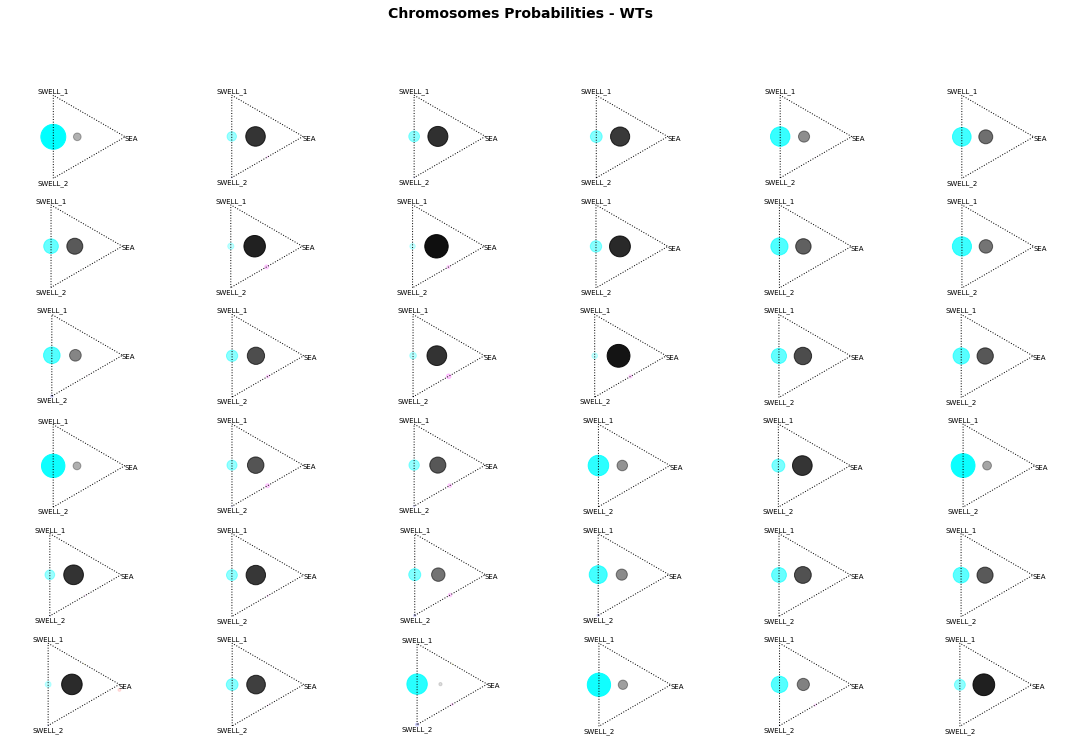

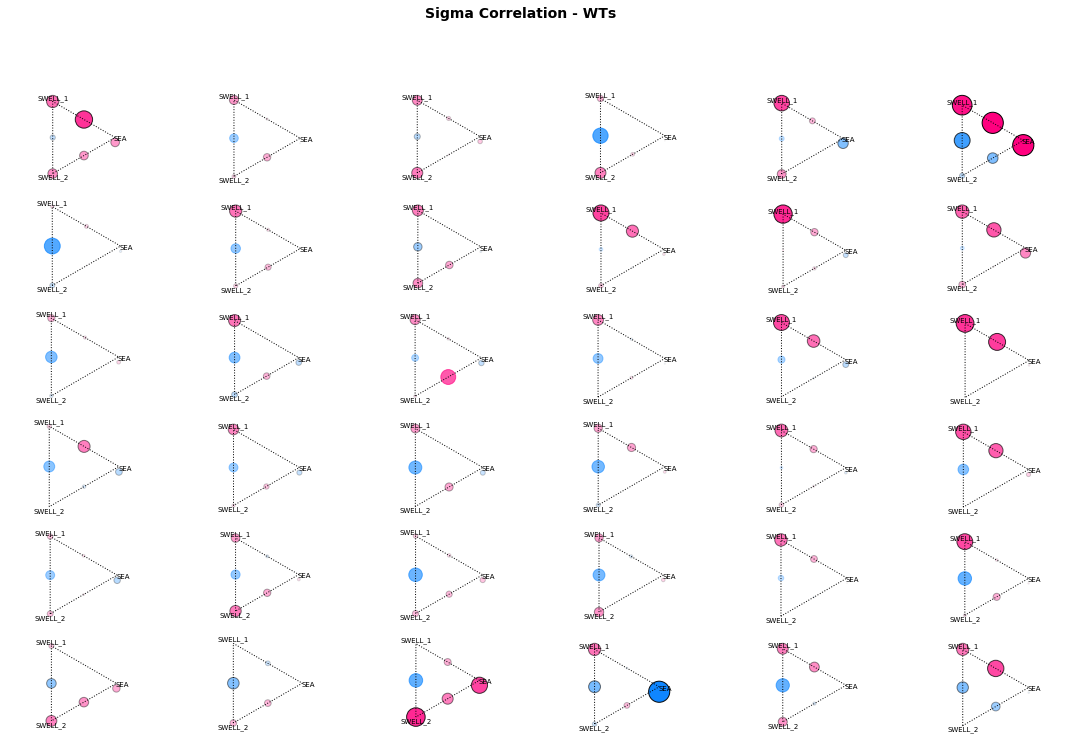

In [5]:
# Fit report figures
CE.Report_Fit();



## Climate Emulator - Simulation

In [6]:
# Select DWT series to simulate
DWTs_sim = DWTs_sim.sel(time=slice('1700-01-01','1950-01-01'), n_sim=0)

print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (time: 91311)
Coordinates:
  * time         (time) object 1700-01-01 00:00:00 ... 1950-01-01 00:00:00
Data variables:
    evbmus_sims  (time) float32 ...


In [7]:
# --------------------------------------
#  Climate Emulator simulation

ce_sims = 10

# Simulate waves
WVS_sim = CE.Simulate_Waves(DWTs_sim, ce_sims, do_filter=False)

# Simulate TCs and update simulated waves
TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)


# Load Climate Emulator Simulations
#WVS_sim, TCs_sim, WVS_upd = CE.LoadSim()


C.E: Sim. TCs  : 100%|██████████| 24624/24624 [00:01<00:00, 15231.11it/s]


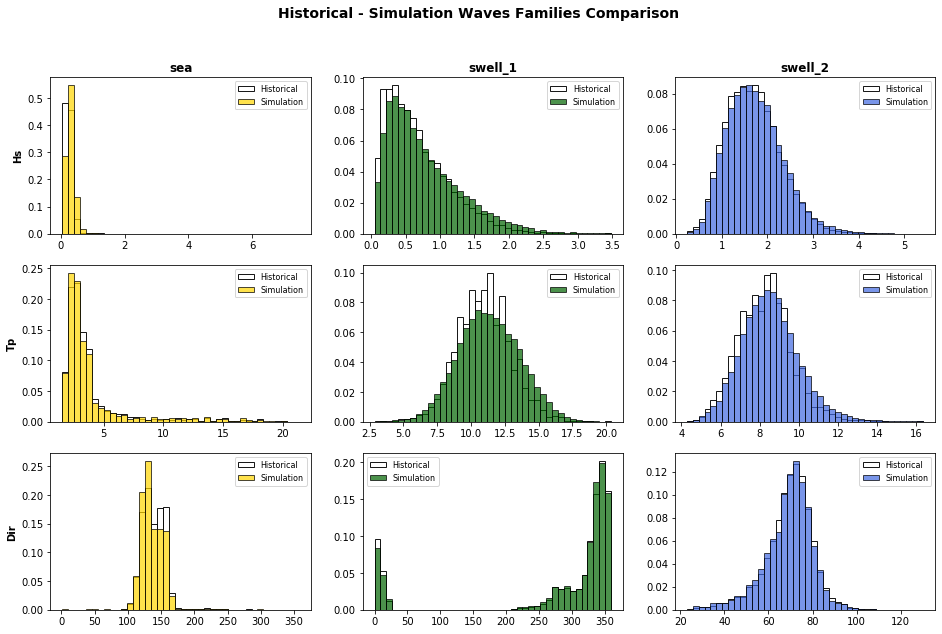

In [8]:
# Plot simulated waves parameters distribution 

Plot_Waves_Histogram_FitSim(WVS_fit, WVS_sim.isel(n_sim=0));
    


## Climate Emulator - Complete Output

In [9]:
# --------------------------------------
# Get all simulated data (hourly): AWTs, DWTs, MJO, MMSL, AT

DATA_sim_h = db.Load_SIM_Covariates(n_sim_awt=0, n_sim_mjo=0, n_sim_dwt=0)

print(DATA_sim_h)


<xarray.Dataset>
Dimensions:  (time: 8765809)
Coordinates:
  * time     (time) object 1700-01-01 1700-01-01T01:00:00 ... 2700-01-01
Data variables:
    AWT      (time) int64 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 2 2 2 2 2 2 2 2 2 2 2 2
    MJO      (time) int64 23 23 23 23 23 23 23 23 23 ... 23 23 23 23 23 23 23 24
    DWT      (time) int64 35 35 35 35 35 35 35 35 35 ... 11 11 11 11 11 11 11 12
    MMSL     (time) float32 -0.007105551 -0.007105551 ... -0.12006987
    AT       (time) float32 -0.6416192 -0.51585776 ... 0.34313485 0.29013193


In [10]:
# --------------------------------------
#  Complete simulation 

# TODO: time profile and optimize
def Simulation_Hourly(wvs_sim, tcs_sim, data_sim):
    '''
    Generate hourly simulation output. 
    
    - aggregate simulated waves storms
    - generate hourly hydrographs
    - complete output data with simulated AWTs, MJO, DWTs, AT, MMSL
    - calculates AWL and TWL
    '''
    
    # iterate simulations
    ls_hy = []
    for i_sim in wvs_sim.n_sim:
        
        # Aggregate waves families
        wvs_agr = Aggregate_WavesFamilies(wvs_sim.sel(n_sim=i_sim))

        # Calculate Intradaily hourly hydrographs for simulated storms
        hy = Intradaily_Hydrograph(wvs_agr, tcs_sim.sel(n_sim=i_sim))
        ls_hy.append(hy)
        
    # combine hourly simulations
    hy = xr.concat(ls_hy, 'n_sim')

    # Complete simulation output 
    d1, d2 = xds_limit_dates([hy, data_sim])
    hy = hy.sel(time = slice(d1, d2))
    dd = data_sim.sel(time = slice(d1, d2))
    hy = xr.merge([hy, dd])
    
    # Calculate hourly Atmospheric Water Level and Total Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)
    hy['TWL'] = TWL(hy.AWL, hy.SS, hy.AT, hy.MMSL)

    return hy
    
    
# Generate simulated hourly data
SIM = Simulation_Hourly(WVS_upd, TCs_sim, DATA_sim_h)  
print(SIM)
    
# Store complete simulations
db.Save_SIM_Complete(SIM)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 2191441)
Coordinates:
  * time     (time) object 1700-01-01 00:00:00 ... 1950-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 0.9308 0.9711 1.011 ... 1.932 1.932 1.932
    Tp       (n_sim, time) float32 9.194971 9.194971 ... 17.110802 6.9367847
    Dir      (n_sim, time) float32 76.38736 76.38736 ... 332.25305 66.03372
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWT      (time) int64 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 2 2 2 2 2 2 2 2 2 2 2 2
    MJO      (time) int64 23 23 23 23 23 23 23 23 23 ... 25 25 25 25 25 25 25 25
    DWT      (time) int64 35 35 35 35 35 35 35 35 35 ... 18 18 18 18 18 18 18 17
    MMSL     (time) float32 -0.007105551 -0.007105551 ... -0.099671654
    AT       (time) float32 -0.6416192 -0.51585776 ... -0.56447786 -0.78587514
    AWL      (n_sim, time) float64 0.4764 0.4867 0.4967 ... 1.277 1.277 0.5179
    TWL      (n_sim, time

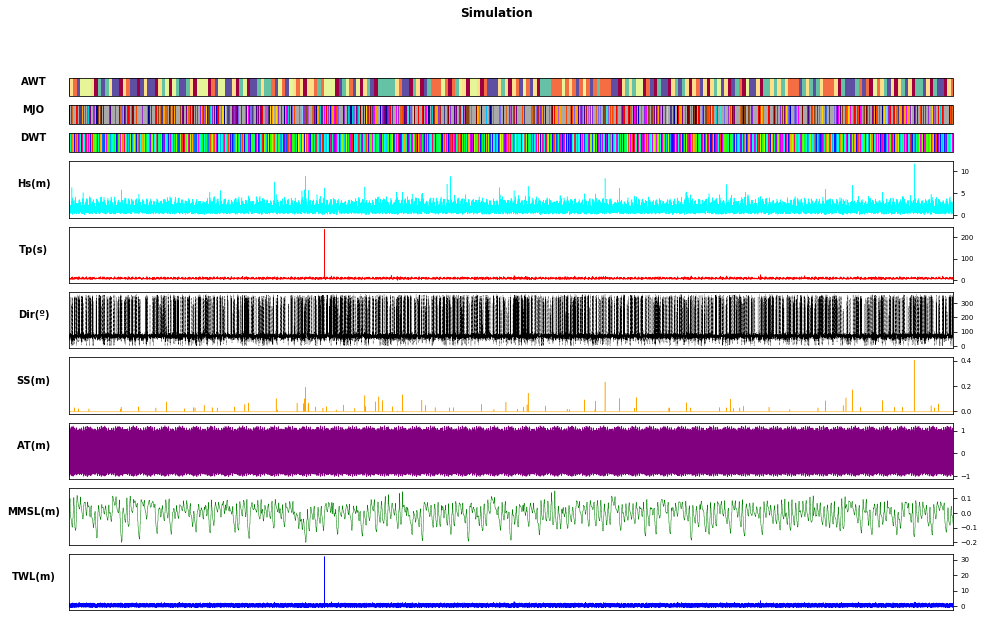

In [11]:
# Plot simulated output

SIM = db.Load_SIM_Complete()

Plot_Simulation(SIM.sel(n_sim=0));


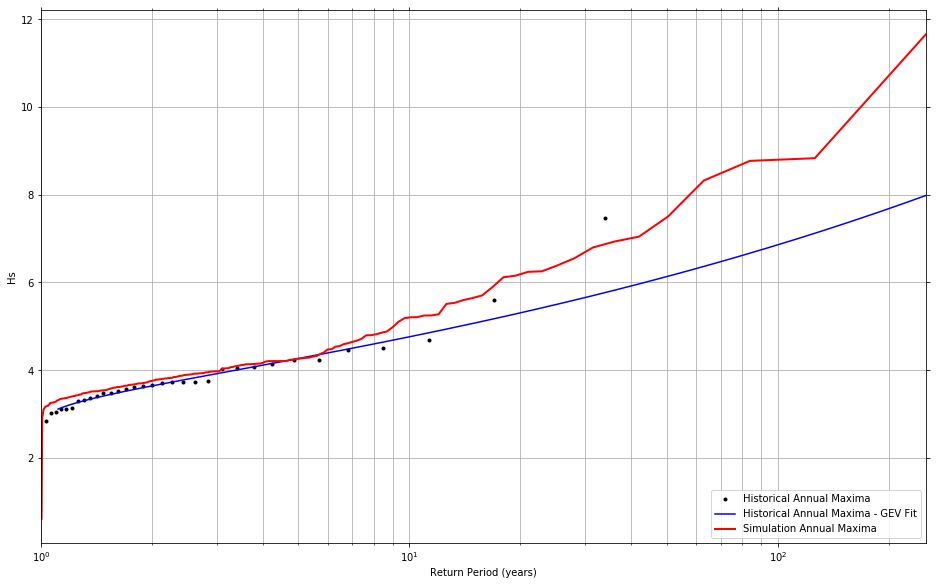

In [13]:
# --------------------------------------
#  Annual Maxima 
var_name = 'Hs'

# historical data (used to fit climate emulator)
hist_Amax = AnnualMaxima(CE.WVS_MS, var_name)

# simulation data
sim_Amax = AnnualMaxima(SIM.sel(n_sim=0), var_name)

# Plot Return Period
# TODO: agregado simulaciones
Plot_ReturnPeriodValidation(hist_Amax, sim_Amax, var_name);
